In [2]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
%matplotlib inline
from IPython import display
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing import image
from datetime import date, datetime

In [3]:
labels = ['camera', 'exit sign', 'fire alarm', 'power outlet', 'sprinkler']

In [4]:
def get_classifier():
    # Initialising the CNN
    classifier = Sequential()

    # Convolution
    classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
    # Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    # Adding a second convolutional layer
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    # Flattening
    classifier.add(Flatten())

    # Full connection
    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units = 5, activation='softmax'))
    # Compiling the CNN
    classifier.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [5]:
# Fitting the CNN to the images
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=180,
                                   width_shift_range=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = image.ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                  target_size = (64, 64),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('dataset/test_set',
                                             target_size = (64, 64),
                                             batch_size = 32,
                                             class_mode = 'categorical')

Found 80 images belonging to 5 classes.
Found 40 images belonging to 5 classes.


In [6]:
def fit_classifier(classifier):
    classifier.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 2,
                             validation_data = test_set,
                             validation_steps = 500,
                             verbose = 2)

In [7]:
# UNCOMMENT below code ONLY if you want to retrain and save classifier (takes ~2.5 hours on 2013 MacBook Pro)
# classifier = get_classifier()
# fit_classifier(classifier)
# classifier.save_weights('cnn_weights_%s.h5' % date.strftime(datetime.now(), '%Y_%m_%d_%H_%M_%S'))
# classifier.save('cnn_model_%s.h5' % date.strftime(datetime.now(), '%Y_%m_%d_%H_%M_%S'))

In [8]:
classifier = load_model('cnn_model_final.h5')

In [9]:
# Making new predictions
test_image = image.load_img('dataset/test_set/sprinkler/20180507_234532.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)
result = classifier.predict(test_image)
training_set.class_indices
print(result[0])
# plt.title(prediction)
# plt.imshow(test_image[0].astype(float))
# plt.show()
# print(count/14)

(1, 64, 64, 3)
[0. 0. 0. 0. 1.]


In [10]:
def backproject(source, target, levels = 2, scale = 1):
    hsv = cv2.cvtColor(source,	cv2.COLOR_BGR2HSV)
    hsvt = cv2.cvtColor(target,	cv2.COLOR_BGR2HSV)
    # calculating object histogram
    roihist = cv2.calcHist([hsv],[0, 1], None, [levels, levels], [0, 180, 0, 256] )

    # normalize histogram and apply backprojection
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256], scale)
    return dst

def saliency_by_backprojection(img):
    cv2.pyrMeanShiftFiltering(img, 2, 10, img, 4)

    backproj = np.uint8(backproject(img, img, levels = 2))
    cv2.normalize(backproj,backproj,0,255,cv2.NORM_MINMAX)
    saliencies = [backproj, backproj, backproj]
    saliency = cv2.merge(saliencies)

    cv2.pyrMeanShiftFiltering(saliency, 20, 200, saliency, 2)
    saliency = cv2.cvtColor(saliency, cv2.COLOR_BGR2GRAY)
    cv2.equalizeHist(saliency, saliency)

    return 255-saliency

def saliency_map(img):
    saliency_hsv = saliency_by_backprojection(img * 1)
    saliency = saliency_hsv
    (T, saliency) = cv2.threshold(saliency, 200, 255, cv2.THRESH_BINARY)
    return saliency

def largest_contours_rect(saliency):
    _, contours, hierarchy = cv2.findContours(saliency * 1,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea)
    return cv2.boundingRect(contours[-1])

def refine_saliency_with_grabcut(img, saliency):
    rect = largest_contours_rect(saliency)
    bgdmodel = np.zeros((1, 65),np.float64)
    fgdmodel = np.zeros((1, 65),np.float64)
    saliency[np.where(saliency > 0)] = cv2.GC_FGD
    mask = saliency
    try:
        cv2.grabCut(img, mask, rect, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_RECT)
    except:
        pass
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    return mask

def backprojection_saliency(img):
    saliency = saliency_map(img)
    mask = refine_saliency_with_grabcut(img, saliency)
    return mask

def bounding_box(mask):
    obj = np.where(mask != 0)
    bbox = np.min(obj[0]), np.max(obj[0]), np.min(obj[1]), np.max(obj[1])
    return bbox

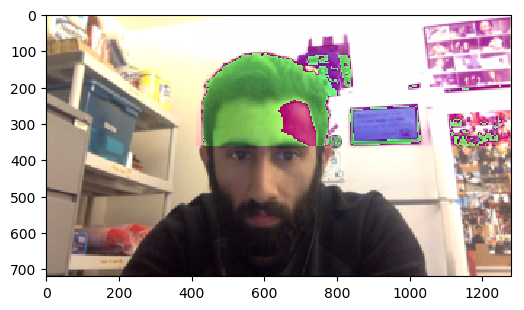

/opt/concourse/worker/volumes/live/ca251eb6-4989-473b-4e46-71e0f4f3e8d3/volume/opencv_1512680485339/work/modules/imgproc/src/color.cpp:11016: error: (-215) scn == 3 || scn == 4 in function cvtColor



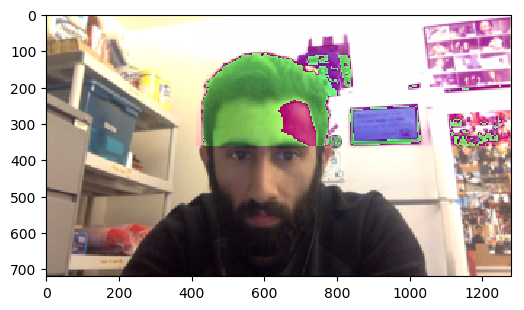

In [12]:
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    print(frame.shape)
    webcam_preview = plt.imshow(frame)   
else:
    is_capturing = False

while is_capturing:
    try:    # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frame = vc.read()
        frame_big = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        frame = imresize(frame_big, (180, 320, 3))
        frame_square = imresize(frame[:, 70:250, :], (64, 64, 3))[np.newaxis,:]
        mask = backprojection_saliency(frame)
        # segmentation = frame*mask[:,:,np.newaxis]
        bbox = bounding_box(mask)
        pred = classifier.predict(frame_square)[0]
        label = labels[np.array(pred).argmax()]
        print(label)
        frame[bbox[0]:bbox[1],bbox[2]:bbox[3],1] = np.clip(2 * frame[bbox[0]:bbox[1],bbox[2]:bbox[3],1], None, 255)
        webcam_preview.set_data(frame)
        plt.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.pause(1)    # the pause time is = 1 / framerate
    except KeyboardInterrupt:
        vc.release()
    except Exception as e:
        print(e)
        continue